#Numerical Solutions for DEs HW2

YANG, Ze (5131209043)

**Note to TA**: Hi, this is the senior student from Antai College who did not register for this course. I would like to do all the assignments for practice, but feel free to just skip my homework if you don't have time.

Thank you again for allowing me to access the assignments and other class material! : )

Ze



##Problem 1.

- Implement RK2
\begin{equation}
\begin{cases}
y_{n+1}=y_n + hk_2 \\
k_1 = f(t_n, y_n) \\
k_2 = f(t_n + \tfrac{1}{2}h, y_n + \tfrac{1}{2}hk_1) \\
\end{cases}
\end{equation}

- Heun Method
\begin{equation}
\begin{cases}
y_{n+1}= y_n + h(\tfrac{1}{4}k_1 + \tfrac{3}{4}k_3)\\
k_1 = f(t_n, y_n) \\
k_2 = f(t_n + \tfrac{1}{3}h, y_n + \tfrac{1}{3}hk_1) \\
k_3 = f(t_n + \tfrac{2}{3}h, y_n + \tfrac{2}{3}hk_1) \\
\end{cases}
\end{equation}

- The Classical RK4 Method
\begin{equation}
\begin{cases}
y_{n+1} = y_n + h(\tfrac{1}{6}k_1 + \tfrac{1}{3}k_2 + \tfrac{1}{3}k_3 + \tfrac{1}{6}k_4) \\
k_1 = f(t_n, y_n) \\
k_2 = f(t_n + \tfrac{1}{2}h, y_n + \tfrac{1}{2}hk_1) \\
k_3 = f(t_n + \tfrac{1}{2}h, y_n + \tfrac{1}{2}hk_2) \\
k_4 = f(t_n + h, y_n + hk_3) \\
\end{cases}
\end{equation}

- Choose appropriate RK method to initialize Adams-Bashforth method of order 3:

\begin{equation}
y_{n+3} = y_{n+2} + h(\tfrac{23}{12}f(t_{n+2}, y_{n+2}) - \tfrac{4}{3}f(t_{n+1}, y_{n+1}) + \tfrac{5}{12}f(t_n, y_n))
\end{equation}

And justify the rate of convergence.

In [2]:
%matplotlib inline
from __future__ import division
import time
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In [2]:
# test cases
test_cases = {
    1: lambda t,y: np.pi * np.cos(np.pi * t),
    2: lambda t,y: t + y,
    3: lambda t,y: np.exp(t),
    4: lambda t,y: -20*y + 20* t + 1,
    5: lambda t,y: (y**2) * (t - t**3),
    6: lambda t,y: t**2 - y
}

# initial conditions
t0, t1, y0 = 0.0, 3.0, 1.0


# estimate error and performance
def err_est(method, f, n_sample, t0, t1, y0):
    """
    estimate the error of an numerical solution relative
    to an exact solution, which is obtained by using a very small h.
    
    @param method: function, the numerical method being used.
    @param f: a function of t and y, which is the derivative of y.
    @param n_sample: # of different choices of h that are tested.
    """
    nks, errs, t_elapsed = [], [], []
    # calculate "exact" solution using a very small h
    n_large = 2**18
    t_ex, y_ex = method(f, n_large, t0, t1, y0)
    
    for k in range(n_sample):
        n_k = 2**(k+3)
        s_k = int(n_large/n_k)
        start_time = time.time()
        # do the numerical procudure with given choice of h,n
        t_path, path = method(f, n_k, t0, t1, y0)
        t_elapsed.append(time.time() - start_time)
        # calc errors 
        path_matched = [y_ex[s_k*i] for i in range(len(path))] 
        err = max(np.abs(path - path_matched))
        errs.append(err)
        nks.append(n_k)
    return nks, errs, t_elapsed


# the benchmark, the method we implemented in last HW.
def explicit_euler_solve(f, n, t0, t1, y0):
    """
    explicit euler method, solve IVP y'(t)=f(t,y(t)), y(t0)=y0 by
    y_{n+1} <- y_{n} + hf(t_n, y_{n}).
    @param f: a function of t and y, which is the derivative of y.
    @param n: the number of steps.
    @param t0, y0: the initial value.
    @param t1: the other end to which we generate numerical solution
    
    @return t: the np.array {t_k}_1^n
    @return y: the np.array {y_k}_1^n
    """
    h = (t1 - t0) / n
    t, y = np.linspace(t0, t1, n+1), np.zeros(n+1)
    y[0] = y0
    for k in range(n):
        y[k+1] = y[k] + h*f(t[k], y[k])
    return t, y


def rk2(f, n, t0, t1, y0):
    """
    2-nd order RK method, solve IVP y'(t)=f(t,y(t)), y(t0)=y0 by
    k1 <- f(t_n, y_n)
    k2 <- f(t_n + h/2, y_n + hk_1/2)
    y_{n+1} <- y_n + hk_2.
    
    @param f: a function of t and y, which is the derivative of y.
    @param n: the number of steps.
    @param h: the step size.
    @param y0: the initial value.
    
    @return t: the np.array {t_k}_1^n
    @return y: the np.array {y_k}_1^n
    """
    h = (t1 - t0) / n
    t, y = np.linspace(t0, t1, n+1), np.zeros(n+1)
    y[0] = y0
    for k in range(n):
        k1 = f(t[k], y[k])
        k2 = f(t[k] + h/2, y[k] + h*k1/2)
        y[k+1] = y[k] + h*k2
    return t, y


def heun_rk3(f, n, t0, t1, y0):
    """
    3-rd order RK method, solve IVP y'(t)=f(t,y(t)), y(t0)=y0 by
    k1 <- f(t_n, y_n)
    k2 <- f(t_n + h/3, y_n + hk_1/3)
    k3 <- f(t_n + 2h/3, y_n + 2hk_2/3)
    y_{n+1} <- y_n + h(k_1/4 + 3k_3/4).
    
    @param f: a function of t and y, which is the derivative of y.
    @param n: the number of steps.
    @param h: the step size.
    @param y0: the initial value.
    
    @return t: the np.array {t_k}_1^n
    @return y: the np.array {y_k}_1^n
    """
    h = (t1 - t0) / n
    t, y = np.linspace(t0, t1, n+1), np.zeros(n+1)
    y[0] = y0
    for k in range(n):
        k1 = f(t[k], y[k])
        k2 = f(t[k] + h/3, y[k] + h*k1/3)
        k3 = f(t[k] + 2*h/3, y[k] + 2*h*k2/3)
        y[k+1] = y[k] + h*(k1/4 + 3*k3/4) 
    return t, y


def rk4(f, n, t0, t1, y0):
    """
    the classical 4-th order RK method, solve IVP y'(t)=f(t,y(t)), y(t0)=y0 by
    k1 <- f(t_n, y_n)
    k2 <- f(t_n + h/2, y_n + hk_1/2)
    k3 <- f(t_n + h/2, y_n + hk_2/2)
    k4 <- f(t_n + h, y_n + hk_3)
    y_{n+1} <- y_n + h(k_1/6 + k_2/3 + k_3/3 + k_4/6).
    
    @param f: a function of t and y, which is the derivative of y.
    @param n: the number of steps.
    @param h: the step size.
    @param y0: the initial value.
    
    @return t: the np.array {t_k}_1^n
    @return y: the np.array {y_k}_1^n
    """
    h = (t1 - t0) / n
    t, y = np.linspace(t0, t1, n+1), np.zeros(n+1)
    y[0] = y0
    for k in range(n):
        k1 = f(t[k], y[k])
        k2 = f(t[k] + h/2, y[k] + h*k1/2)
        k3 = f(t[k] + h/2, y[k] + h*k2/2)
        k4 = f(t[k] + h, y[k] + h*k3)
        y[k+1] = y[k] + h*(k1/6 + k2/3 + k3/3 + k4/6) 
    return t, y


def abf3(f, n, t0, t1, y0):
    """
    the 3-rd Adams Bashforth multistep method, 
    solve IVP y'(t)=f(t,y(t)), y(t0)=y0 by
    
    y_{n+3} <- y_n + h(
        23/12 * f(t_{n+2}, y_{n+2}) 
        - 4/3 * f(t_{n+1}, y_{n+1}) 
        + 5/12 * f(t_n, y_n)
    ).
    
    the method uses a (higher than) 3-rd ordered one-step (rk3) method 
    to generate another two initial values. 
    Here we use the heun_rk3
    
    @param f: a function of t and y, which is the derivative of y.
    @param n: the number of steps.
    @param h: the step size.
    @param y0: the initial value.
    
    @return t: the np.array {t_k}_1^n
    @return y: the np.array {y_k}_1^n
    """
    h = (t1 - t0) / n
    t_init, y_init = heun_rk3(f, 2, t0, t0+2*h, y0)
    t, y = np.linspace(t0, t1, n+1), np.zeros(n+1)
    y[0], y[1], y[2] = y0, y_init[1], y_init[2]
    for k in range(n-2):
        y[k+3] = y[k+2] + h*((23/12) * f(t[k+2], y[k+2]) + 
                             (-4/3) * f(t[k+1], y[k+1]) + 
                             (5/12) * f(t[k], y[k]))
    return t, y

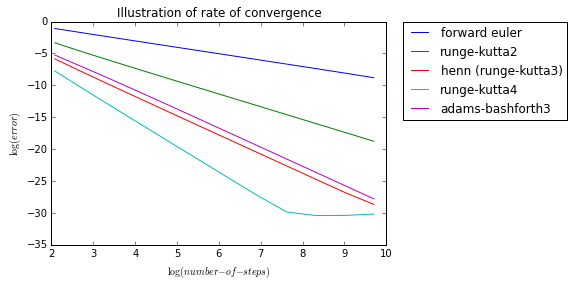

In [3]:
if __name__ == '__main__':
    nks ,errs, t_elapsed = err_est(explicit_euler_solve, test_cases[6], 12, t0, t1, y0)
    nks2 ,errs2, t_elapsed2 = err_est(rk2, test_cases[6], 12, t0, t1, y0)
    nks3 ,errs3, t_elapsed3 = err_est(heun_rk3, test_cases[6], 12, t0, t1, y0)
    nks4 ,errs4, t_elapsed4 = err_est(rk4, test_cases[6], 12, t0, t1, y0)
    nks5 ,errs5, t_elapsed5 = err_est(abf3, test_cases[6], 12, t0, t1, y0)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.log(nks) ,np.log(errs))
    ax.plot(np.log(nks2) ,np.log(errs2))
    ax.plot(np.log(nks3) ,np.log(errs3))
    ax.plot(np.log(nks4) ,np.log(errs4))
    ax.plot(np.log(nks5) ,np.log(errs5))
    ax.set_title('Illustration of rate of convergence')
    ax.set_xlabel('$\log(number-of-steps)$')
    ax.set_ylabel('$\log(error)$')
    ax.legend(['forward euler', 'runge-kutta2', 'heun (runge-kutta3)', 'runge-kutta4', 'adams-bashforth3'],
              bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)




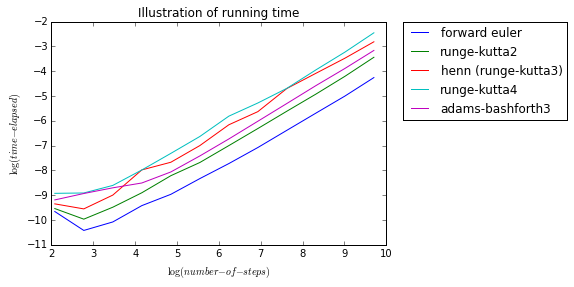

In [4]:
    fig = plt.figure()
    ax = fig.add_subplot(111)    
    ax.plot(np.log(nks), np.log(t_elapsed))
    ax.plot(np.log(nks2), np.log(t_elapsed2))
    ax.plot(np.log(nks3), np.log(t_elapsed3))
    ax.plot(np.log(nks4), np.log(t_elapsed4))
    ax.plot(np.log(nks5), np.log(t_elapsed5))
    ax.set_title('Illustration of running time')
    ax.set_xlabel('$\log(number-of-steps)$')
    ax.set_ylabel('$\log(time-elapsed)$')
    ax.legend(['forward euler', 'runge-kutta2', 'heun (runge-kutta3)', 'runge-kutta4', 'adams-bashforth3'],
              bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

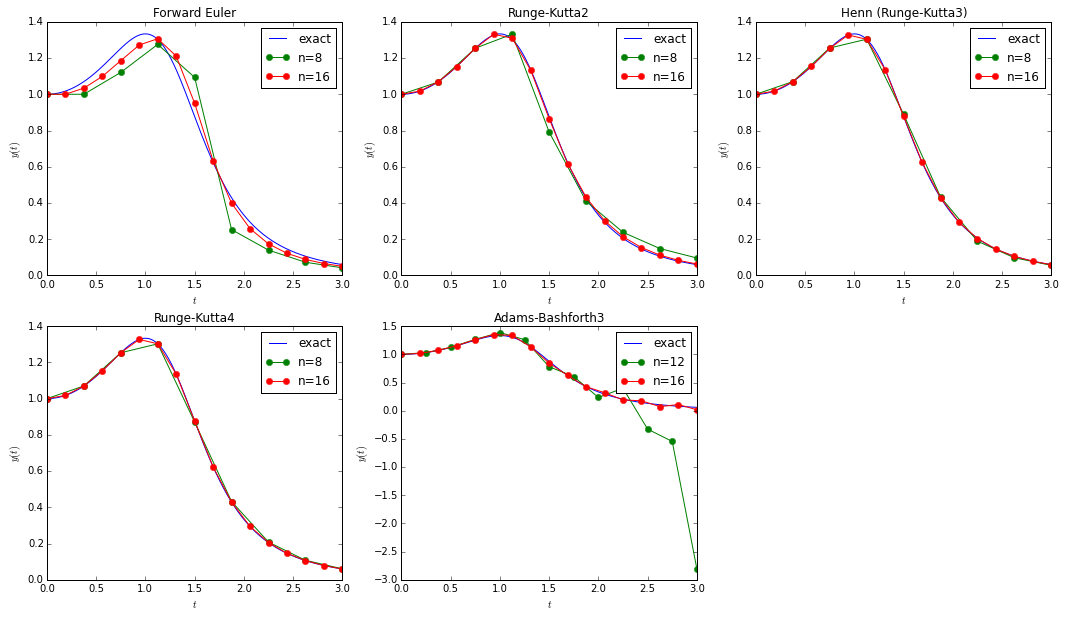

In [5]:
# initial conditions
fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)

t_ex, y_ex = explicit_euler_solve(test_cases[5], 2**16, 0.0, 3.0, 1.00)
t1, y1 = explicit_euler_solve(test_cases[5], 8, 0.0, 3.0, 1.0)
t2, y2 = explicit_euler_solve(test_cases[5], 16, 0.0, 3.0, 1.0)
ax1.plot(t_ex, y_ex)
ax1.plot(t1, y1, '.-', markersize=12)
ax1.plot(t2, y2, '.-', markersize=12)
ax1.set_title('Forward Euler')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$y(t)$')
ax1.legend(['exact', 'n=8', 'n=16'])

t_ex, y_ex = rk2(test_cases[5], 2**16, 0.0, 3.0, 1.00)
t1, y1 = rk2(test_cases[5], 8, 0.0, 3.0, 1.0)
t2, y2 = rk2(test_cases[5], 16, 0.0, 3.0, 1.0)
ax2.plot(t_ex, y_ex)
ax2.plot(t1, y1, '.-', markersize=12)
ax2.plot(t2, y2, '.-', markersize=12)
ax2.set_title('Runge-Kutta2')
ax2.set_xlabel('$t$')
ax2.set_ylabel('$y(t)$')
ax2.legend(['exact', 'n=8', 'n=16'])

t_ex, y_ex = heun_rk3(test_cases[5], 2**16, 0.0, 3.0, 1.00)
t1, y1 = heun_rk3(test_cases[5], 8, 0.0, 3.0, 1.0)
t2, y2 = heun_rk3(test_cases[5], 16, 0.0, 3.0, 1.0)
ax3.plot(t_ex, y_ex)
ax3.plot(t1, y1, '.-', markersize=12)
ax3.plot(t2, y2, '.-', markersize=12)
ax3.set_title('Heun (Runge-Kutta3)')
ax3.set_xlabel('$t$')
ax3.set_ylabel('$y(t)$')
ax3.legend(['exact', 'n=8', 'n=16'])

t_ex, y_ex = heun_rk3(test_cases[5], 2**16, 0.0, 3.0, 1.00)
t1, y1 = rk4(test_cases[5], 8, 0.0, 3.0, 1.0)
t2, y2 = rk4(test_cases[5], 16, 0.0, 3.0, 1.0)
ax4.plot(t_ex, y_ex)
ax4.plot(t1, y1, '.-', markersize=12)
ax4.plot(t2, y2, '.-', markersize=12)
ax4.set_title('Runge-Kutta4')
ax4.set_xlabel('$t$')
ax4.set_ylabel('$y(t)$')
ax4.legend(['exact', 'n=8', 'n=16'])

t_ex, y_ex = abf3(test_cases[5], 2**16, 0.0, 3.0, 1.00)
t1, y1 = abf3(test_cases[5], 12, 0.0, 3.0, 1.0)
t2, y2 = abf3(test_cases[5], 16, 0.0, 3.0, 1.0)
ax5.plot(t_ex, y_ex)
ax5.plot(t1, y1, '.-', markersize=12)
ax5.plot(t2, y2, '.-', markersize=12)
ax5.set_title('Adams-Bashforth3')
ax5.set_xlabel('$t$')
ax5.set_ylabel('$y(t)$')
ax5.legend(['exact', 'n=12', 'n=16'])

##Problem 4.

- Find the region of absolute stability for the multistep method

$$
y_{n+2} - y_n = \tfrac{1}{3}h[f(t_{n+2}, y_{n+2}) + 4f(t_{n+1}, y_{n+1}) + f(t_n, y_n)]
$$

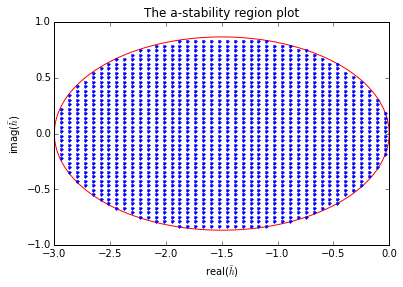

In [6]:
h1 = lambda z: (z**2 - z)/(z**2/3 +4*z/3 + 1/3)

def aStabRegion_boundary(h_bar_func):
    """
    Compute the boundary of absolute stability h_bar in the 
    complex plane. Using the fact that 
    \partial S = {h_bar(z) : |z| = 1}. We take z = exp(i*theta),
    with theta ranging from 0 to 2pi.
    
    @param h_bar_func: the functional of h_bar of z -> complex, z is the 
    root to \Pi(z, h_bar) = 0.
    """
    theta = np.linspace(0, 2*np.pi, 1000)
    z = np.exp(theta*1j)
    h_bar = h_bar_func(z)
    return h_bar.real, h_bar.imag

z1 = lambda h: [
    (np.sqrt(12*h**2 + 36*h + 9) - 4*h - 3) / (2*h - 6),
    (-np.sqrt(12*h**2 + 36*h + 9) - 4*h - 3) / (2*h - 6),
]

def aStabRegion_mesh(x_lim, y_lim, root_funcs):
    """
    Collect the points on the mesh grids where the method
    is absolute stable. By testing whether all roots of \Pi(z, h_bar) = 0.
    have modulus smaller than 1.
    
    @param x_lim: tuple of 2 doubles, the real range on which the
    stability test is conducted.
    @param y_lim: tuple of 2 doubles, the imag range on which the
    stability test is conducted.
    @param root_funcs: list of functionals of h_bar -> complex,
    the roots of \Pi(z, h_bar) = 0.
    """
    x_in, y_in = [], []
    x_grids = np.linspace(x_lim[0], x_lim[1], 100)
    y_grids = np.linspace(y_lim[0], y_lim[1], 100)
    for x in x_grids:
        for y in y_grids:
            h = x + y*1j
            z_all = root_funcs(h)
            # conduct the test
            test = sum([np.abs(z)>=1 for z in z_all])
            if test == 0:
                x_in.append(x)
                y_in.append(y)
    return x_in, y_in
            
if __name__ == '__main__':
    x, y = aStabRegion_boundary(h1)
    x_pp, y_pp = aStabRegion_mesh([-4, 3], [-2, 2], z1)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, y, '-', color='r')
    ax.plot(x_pp, y_pp, '.')
    ax.set_title('The a-stability region plot')
    ax.set_xlabel('real($\\bar{h}$)')
    ax.set_ylabel('imag($\\bar{h}$)')
